### Visualization of mutagenic spectra
1. On the codon level (mainly for RL8)
2. On the AA level (for RL8 and DP6)

In [1]:
import os
import json

from Bio.SeqIO import QualityIO
import numpy as np
# import re
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
from functions_ import *
from plotting import *
from Bio import SeqIO
from Bio.Seq import Seq
from Illumina_functions import *
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar  # Import colorbar module

In [2]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    #"#2C3E5E",  
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
] , N=256)

custom_params = {"axes.spines.right": False, "axes.spines.top": False,'axes.linewidth':1}
sns.set_theme(context="paper",
              style='ticks',
              palette="Greys_r",rc=custom_params
             )
plt.rcParams['svg.fonttype'] = 'none'
lw = 1
lw = 1
fs = 7
hi = 10.5 *0.75 # 6.69291
wi3 = 2.24 # 7.08661
wi2 = 4.76
wi1 = 7.24
nr = 5

short_fn = np.vectorize(lambda x: x[:5])
#matplotlib.rcParams.update({'font.size': fs})
matplotlib.rcParams['axes.linewidth'] = 1
sns.set_context("paper", rc={"font.size":fs,
                             "axes.titlesize":fs+1,
                             "axes.labelsize":fs,
                             'axes.linewidth':1,    
                            "xtick.labelsize": fs,
                            "ytick.labelsize": fs,
                            "legend.fontsize": fs,
                            "legend.title_fontsize": fs+1}) 

In [6]:
amplicon_AraCLOV2 = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
start_LOV2  = "ttagccacaa".upper() ## LOV2 start # set region of interest, that has to be included in the reads to be considered for the analysis, e.g. LOV2 start site
end_LOV2 = "cggccaaa".upper() ## LOV2 end

LOV2_gene = amplicon_AraCLOV2[amplicon_AraCLOV2.index(start_LOV2):amplicon_AraCLOV2.index(end_LOV2)+len(end_LOV2)]

ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}


genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


In [ ]:
### get enrichment 
Folder = "/home/student/anna/DMS_analysis/final_output/RL8/combined/enrichments/Codons/" 
enrichment = pd.read_csv(f"{Folder}/RL8_BC1_S1_combined_roiTrue_Codons_enrichment_relative.csv", index_col = 0)

In [ ]:
empty_cols = enrichment.columns[enrichment.isna().all()]

max_col = enrichment.sum().idxmax()
enrichment[max_col] = np.nan ## mask silent mutation that is present in almost 100% of all phages

enrichment.fillna(0, inplace=True)
ref =LOV2_gene
mut_spectrum_codons,mut_spectrum_codons_perc = calc_mut_spectrum_from_enrichment(enrichment, ref_seq=ref, data_type="Codons")


In [24]:

## filtering of mutagenic spectrum for plotting 
ref_len = len(enrichment.columns) * 3 ## Nts instead of codons
ref_len = ref_len + amplicon_AraCLOV2.index(start_LOV2) ## include start of LOV2

ref_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0,ref_len, 3)]

ref_codons = [codon for idx, codon in enumerate(ref_codons) if str(idx) not in empty_cols] ## do not consider pos that are excluded in the mutagenic spectrum due to low coverage

pref_codons = sorted(ecoli_pref.values())



## order the mutagenic spectrum according to the pref codons and filter for the reference codons
mut_spec_perc_ordered = pd.concat((mut_spectrum_codons_perc.loc[:,pref_codons], mut_spectrum_codons_perc.loc[:,[codon for codon in codons if codon not in pref_codons]]),axis = 1)## order after in pref vs not in pref
mut_spec_perc_ordered = mut_spec_perc_ordered.loc[[codon for codon in codons if codon in ref_codons],:] # throw out reference codons not in ref
mut_spec_perc_ordered = mut_spec_perc_ordered.reindex(sorted(mut_spec_perc_ordered.index), axis=0) # reorder rows alphabetically

## find codons that are included in (non-targeted) AraC but not in (targeted) LOV sequence
## find start position of LOV2 in seq
LOVstart = amplicon_AraCLOV2.index(start_LOV2)
AraC_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0, LOVstart, 3)] # AraC codons
LOV_codons = [amplicon_AraCLOV2[i:i+3] for i in range(LOVstart, ref_len, 3)] # LOV codons
## filter codons that are only in AraC but not LOV2 seq
AraC_spec_codons = [codon for codon in AraC_codons if codon not in LOV_codons]

## count occs 
counter_LOV = Counter(LOV_codons)
for codon in mut_spec_perc_ordered.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
## sort after key
        
counter_LOV = dict(sorted(counter_LOV.items()))
### annotations: 
col_annot = [0 if codon in pref_codons else 1 for codon in mut_spec_perc_ordered.columns]
row_annots = list(counter_LOV.values())
# convert row_annot to colors of cmap




row_cmap = plt.get_cmap('Greys').reversed()
norm = plt.Normalize(min(row_annots), max(row_annots))
row_annot = [row_cmap(norm(value)) for value in row_annots]

colors = ["#22577A", "#C7F9CC"] # Light green to light blue

cmap =  LinearSegmentedColormap.from_list("custom_cmap", colors , N=256)


colors = [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
]

# Create the colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)



In [25]:


row_cmap = plt.get_cmap('Greys').reversed()


colors = ["darkgrey", "lightgrey"]

# Create the colormap
col_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)



colors = [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
]

# Create the colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)

row_annot_df = pd.DataFrame(row_annots, index=mut_spec_perc_ordered.index)  # Row annotations as DataFrame
col_annot_df = pd.DataFrame(col_annot).T  # Column annotations as DataFrame

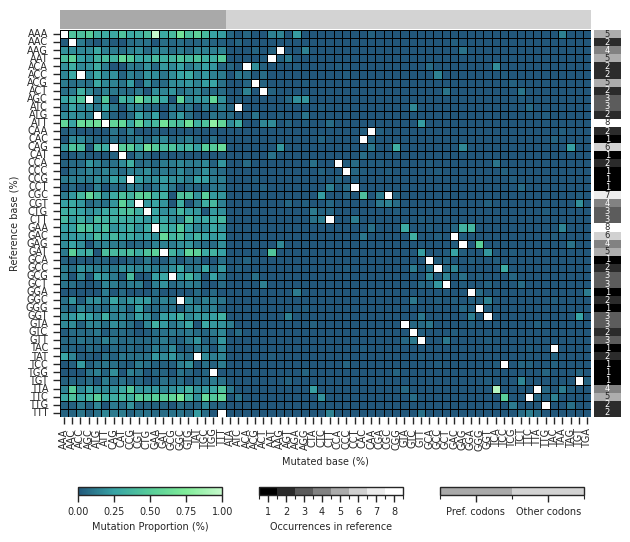

In [31]:
# Create figure and subplots
fig, axes = plt.subplots(4, 2, figsize=(wi1, hi*0.7), 
                         gridspec_kw={"height_ratios": [0.05, 1, 0.02, 0.02], "width_ratios": [1, 0.05]})

plt.subplots_adjust(hspace=0.01, wspace=0.01)

# Column annotation heatmap (top)
sns.heatmap(col_annot_df, cmap=col_cmap, cbar=False, ax=axes[0, 0], xticklabels=False, yticklabels=False)
axes[0, 1].axis("off")

# Main heatmap (center)
sns.heatmap(mut_spec_perc_ordered, cmap=cmap, cbar=False, ax=axes[1, 0], xticklabels=True, yticklabels=True, linecolor="black", linewidths=0.5)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticklabels(), rotation=0)
axes[1, 0].set_xlabel('Mutated base (%)')
axes[1, 0].set_ylabel('Reference base (%)')

# Row annotation heatmap (right)
sns.heatmap(row_annot_df, cmap=row_cmap, cbar=False, ax=axes[1, 1], xticklabels=False, yticklabels=False, annot=True, annot_kws={"size": 6})


# Create colorbars
cbar_ax1 = fig.add_axes([0.15, 0.0, 0.2, 0.015])  # Position for main heatmap colorbar
cbar_ax2 = fig.add_axes([0.4, 0.0, 0.2, 0.015])  # Position for row annotation colorbar
cbar_ax3 = fig.add_axes([0.65, 0.0, 0.2, 0.015])  # Position for column annotation colorbar

# Colorbar for main heatmap (continuous)
cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Mutation Proportion (%)")

# Colorbar for row annotation (discrete)
norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(row_annot_df)+1.5, 1), ncolors=row_cmap.N)
cbar2 = mcolorbar.ColorbarBase(cbar_ax2, cmap=row_cmap, norm=norm,
                               orientation="horizontal", ticks=np.arange(1, np.max(row_annot_df)+1,1))
cbar2.set_label("Occurrences in reference")

norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(col_annot_df)+2.5, 1), ncolors=col_cmap.N)
cbar3 = mcolorbar.ColorbarBase(cbar_ax3, cmap=col_cmap, norm=norm,
                               orientation="horizontal", ticks=np.arange(1, np.max(col_annot_df)+1.5,1))
cbar3.set_ticklabels(["Pref. codons", "Other codons"])

axes[2, 0].axis("off")
axes[2, 1].axis("off")
axes[3, 0].axis("off")
axes[3, 1].axis("off")


plt.savefig(f"{Folder}/Codons_mutagenic_spectrum_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.savefig(f"{Folder}/Codons_mutagenic_spectrum_perc_ordered_Annot.png", bbox_inches="tight")
plt.show()

## AA level

In [85]:
variant = "DP6" ## RL8
dat = "AA"
variant_name = "P01_DP6_LOV2" ##P02_RL8_LOV2
### get enrichment 
homedir = f"/home/student/anna/DMS_analysis/data/fastq/{variant_name}"
Folder = f"/home/student/anna/DMS_analysis/final_output/{variant}/combined/" 
mut_spectrum_AA_perc = pd.read_csv(f"{Folder}/enrichments/{dat}/{variant}_BC1_S1_combined_roiTrue_{dat}_mut_spec.csv", index_col = 0)
enrichment = pd.read_csv(f"{Folder}/enrichments/{dat}/{variant}_BC1_S1_combined_roiTrue_{dat}_enrichment_relative.csv", index_col = 0)
FigFolder = Folder+ f"/plots/{dat}/"

empty_cols = enrichment.columns[enrichment.isna().all()]

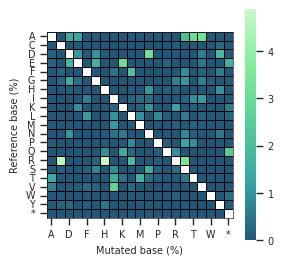

In [86]:
enrichment.fillna(0, inplace=True)
ref = translate_dna2aa(LOV2_gene) if dat != "DNA" else LOV2_gene
mut_spectrum_AA,mut_spectrum_AA_perc = calc_mut_spectrum_from_enrichment(enrichment, ref_seq=ref, data_type=dat)
plot_mutation_spectrum(mut_spectrum_AA_perc, data_type=dat, colormap=cmap)

In [87]:
LOV2_AAs_all = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
LOV2_AAs = []
for idx,LOV_aa in enumerate(LOV2_AAs_all):
    if str(idx) not in empty_cols: 
        LOV2_AAs.append(LOV_aa)
LOV2_AAs = "".join(LOV2_AAs)


In [88]:

## count occs
counter_LOV = Counter(LOV2_AAs)
for codon in mut_spectrum_AA_perc.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
## sort after key but with "*" at the end
counter_LOV = dict(sorted(counter_LOV.items(), key = lambda x: x[0] if x[0] != "*" else "Z"))
### annotations: 

row_annot = list(counter_LOV.values())
# convert row_annot to colors of cmap


row_cmap = plt.get_cmap('Greys').reversed()
norm = plt.Normalize(min(row_annot), max(row_annot))
#row_annot = [row_cmap(norm(value)) for value in row_annot]

colors = ["#22577A", "#C7F9CC"] # Light green to light blue

cmap =  LinearSegmentedColormap.from_list("custom_cmap", colors , N=256)


colors = [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
]

# Create the colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)



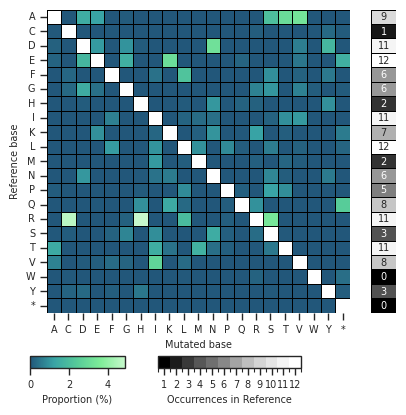

In [89]:
######### not normalized but rows annotated 
fig, axes = plt.subplots(1, 2, figsize=(wi2, hi/2), gridspec_kw={"width_ratios": [4, 0.3]})
fig.subplots_adjust(wspace=0.01)

sns.heatmap(mut_spectrum_AA_perc, annot=False, linecolor = "black", cmap = cmap,  xticklabels=True,yticklabels = True, ax=axes[0], cbar = False, linewidths=.5, square=True)

sns.heatmap(pd.DataFrame(row_annot), cmap=row_cmap, annot=True, linewidths=.5,linecolor="black" ,
            xticklabels=False, yticklabels=True, ax=axes[1], cbar=False)

# Adjust layout
axes[1].set_yticks([])  # Remove yticks from annotation column
axes[1].set_ylabel("") 


axes[0].set_xlabel('Mutated base')
axes[0].set_ylabel('Reference base')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation = 0)

# plt.title(f"{name} mutagenic spectrum", fontsize = 12)

cbar_ax = fig.add_axes([0.13, -0.03, 0.2, 0.03])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("Proportion (%)")

cbar_ax2 = fig.add_axes([0.4, -0.03, 0.3, 0.03])  # Position the second colorbar
norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(row_annot)+1.5, 1), ncolors=row_cmap.N)

cbar2 = mcolorbar.ColorbarBase(cbar_ax2, cmap=row_cmap, norm=norm,
                               orientation="horizontal", ticks=np.arange(1, np.max(row_annot)+1,1))

cbar2.set_label("Occurrences in Reference")

plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_roi_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_roi_perc_ordered_Annot.png", bbox_inches="tight")
plt.show()